# Visualizing predictions

AlphaGenome can make predictions for various different modalities. We built a visualization library to aid interpretation of the outputs from the model. In this tutorial notebook you will:
*   Learn how to visualize different data modalities for a specific genomic interval (and any variants) from model output.
*   Understand how to use the primary functionality of the visualization library `alphagenome.visualization`.

We also recommend visiting ["Visualization Basics"](https://www.alphagenomedocs.com/visualization_library_basics.html) for an overview of the library and its primary functionality.

```{tip}
Open this tutorial in Google Colab for interactive viewing.
```

In [1]:
# @title Install AlphaGenome

# @markdown Run this cell to install AlphaGenome.
from IPython.display import clear_output
! pip install alphagenome
clear_output()

## Setup and imports

In [2]:
from alphagenome import colab_utils
from alphagenome.data import gene_annotation, genome, track_data, transcript
from alphagenome.models import dna_client
from alphagenome.visualization import plot_components
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### Load model and auxiliary objects

In [4]:
dna_model = dna_client.create(colab_utils.get_api_key())

In [5]:
# Load metadata objects for human.
output_metadata = dna_model.output_metadata(
    organism=dna_client.Organism.HOMO_SAPIENS
)

In [6]:
output_metadata

OutputMetadata(atac=                        name strand Assay title  ontology_curie  \
0        CL:0000084 ATAC-seq      .    ATAC-seq      CL:0000084   
1        CL:0000100 ATAC-seq      .    ATAC-seq      CL:0000100   
2        CL:0000236 ATAC-seq      .    ATAC-seq      CL:0000236   
3        CL:0000623 ATAC-seq      .    ATAC-seq      CL:0000623   
4        CL:0000624 ATAC-seq      .    ATAC-seq      CL:0000624   
..                       ...    ...         ...             ...   
162  UBERON:0008953 ATAC-seq      .    ATAC-seq  UBERON:0008953   
163  UBERON:0008971 ATAC-seq      .    ATAC-seq  UBERON:0008971   
164  UBERON:0010414 ATAC-seq      .    ATAC-seq  UBERON:0010414   
165  UBERON:0011907 ATAC-seq      .    ATAC-seq  UBERON:0011907   
166  UBERON:0015143 ATAC-seq      .    ATAC-seq  UBERON:0015143   

                      biosample_name                 biosample_type  \
0                             T-cell                   primary_cell   
1                       motor neu

In [7]:
# Load gene annotations (from GENCODE).
gtf = pd.read_feather(
    'https://storage.googleapis.com/alphagenome/reference/gencode/'
    'hg38/gencode.v46.annotation.gtf.gz.feather'
)

# Filter to protein-coding genes and highly supported transcripts.
gtf_transcript = gene_annotation.filter_transcript_support_level(
    gene_annotation.filter_protein_coding(gtf), ['1']
)

# Extractor for identifying transcripts in a region.
transcript_extractor = transcript.TranscriptExtractor(gtf_transcript)

# Also define an extractor that fetches only the longest transcript per gene.
gtf_longest_transcript = gene_annotation.filter_to_longest_transcript(
    gtf_transcript
)
longest_transcript_extractor = transcript.TranscriptExtractor(
    gtf_longest_transcript
)

## Gene expression

Gene expression is primarily captured by the model outputs `RNA_SEQ` and `CAGE`.
Here is an example of expression predictions for colon tissue in a genomic
interval containing the gene *APOL4* . Positions of the longest transcript per
gene for genes in this interval are shown at the top:

In [8]:
# Define interval to make predictions for (used throughout this tutorial).
# Note that the interval width must be one of the supported sequence lengths.
interval = genome.Interval('chr22', 36_150_498, 36_252_898).resize(
    dna_client.SEQUENCE_LENGTH_1MB
)

# Define the tissues/cell-types to predict expression for.
ontology_terms = [
    'UBERON:0001159',  # Colon - Sigmoid.
    'UBERON:0001155',  # Colon - Transverse.
]

# Make predictions.
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CAGE,
    },
    ontology_terms=ontology_terms,
)

# Extract the longest transcripts per gene for this interval.
longest_transcripts = longest_transcript_extractor.extract(interval)

Build the plot by constructing multiple plotting panels or 'components' and
feeding these into the `plot_components.plot()` function. Refer to
[visualization basics guide](https://www.alphagenomedocs.com/visualization_library_basics.html#visualization-basics)
for a description of available plotting components.

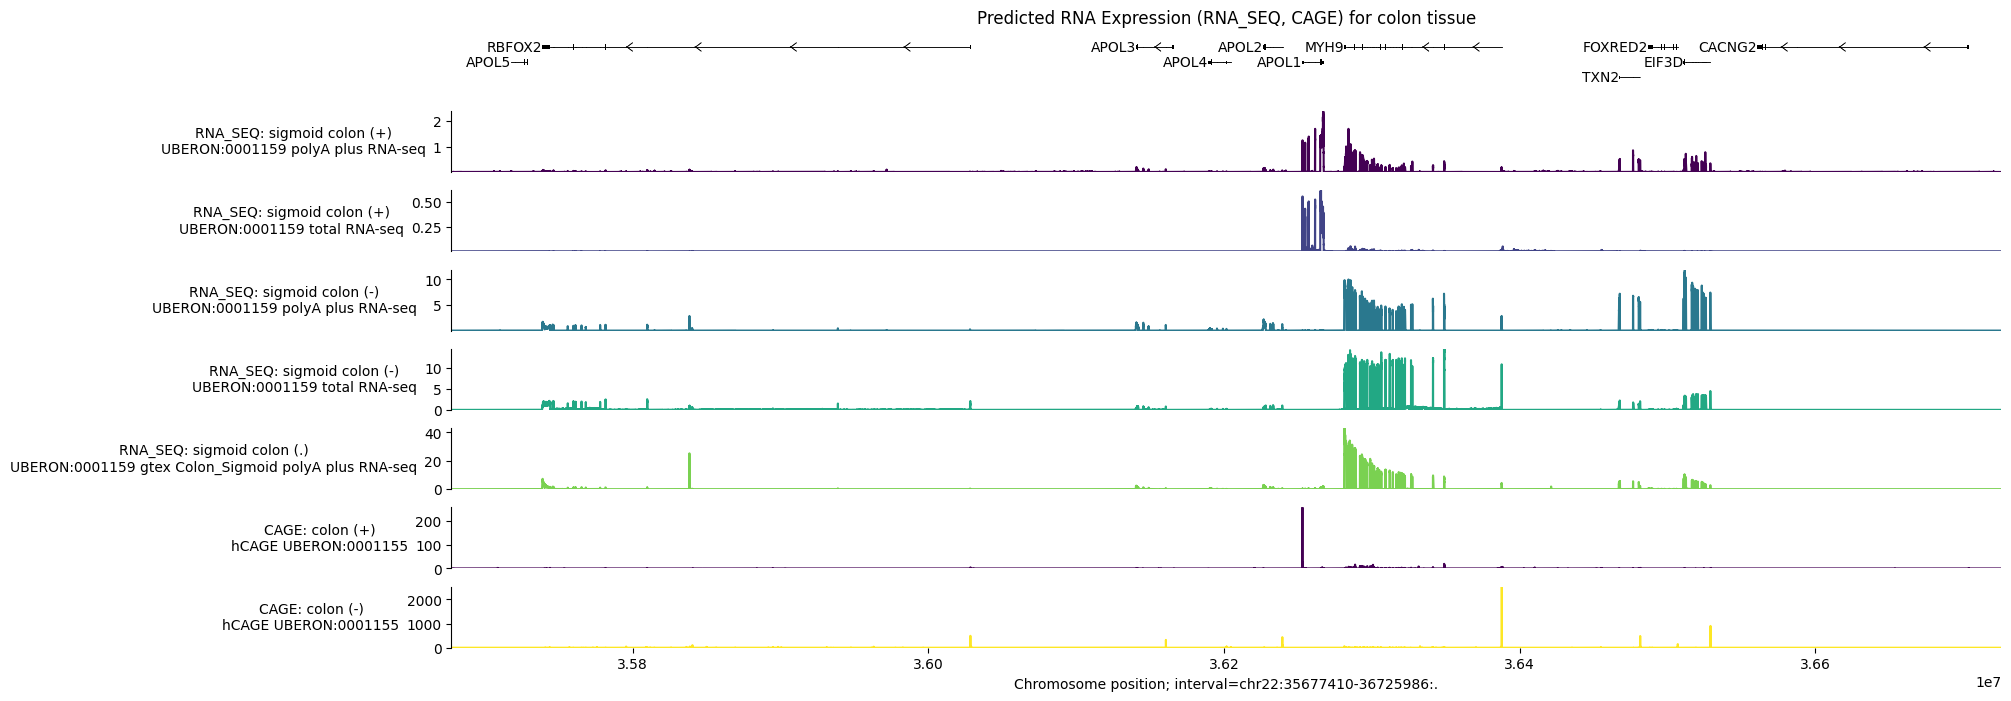

In [9]:
# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=output.rna_seq,
            ylabel_template='RNA_SEQ: {biosample_name} ({strand})\n{name}',
        ),
        plot_components.Tracks(
            tdata=output.cage,
            ylabel_template='CAGE: {biosample_name} ({strand})\n{name}',
        ),
    ],
    interval=interval,
    title='Predicted RNA Expression (RNA_SEQ, CAGE) for colon tissue',
)

Note that the positive and negative stranded tracks have clearly different
signals. Let's check which genes are transcribed from the positive strand:

In [10]:
[t.info['gene_name'] for t in longest_transcripts if t.strand == '+']

['APOL5', 'APOL1']

For both of the positive stranded `RNA_SEQ` tracks, we can see that RNA-seq
levels are highest around *APOL1*. Similarly for `CAGE`, the peaks on the
positive strand fall around the start of this gene. We do not see peaks around
*APOL5* as this gene is not expressed in colon tissue
[(GTEx)](https://www.gtexportal.org/home/gene/APOL5#geneExpression).

### Visualize the effect of a variant

A previously identified variant in this region (`chr22_36201698_A_C`) affects
both the expression and splicing of the *APOL4* gene. Specifically, the
alternative allele (C) is linked to reduced *APOL4* expression.

To visualize what AlphaGenome predicts for this variant, we can:

*   Compute predictions for the REF and ALT sequences using
    `dna_model.predict_variant`.
*   Remove positive-stranded tracks (as *APOL4* is transcribed from the negative
    DNA strand).
*   Zoom in to the region around the gene *APOL4*.
*   Highlight the location of the variant using
    `plot_components.VariantAnnotation`.
*   Increase the relative height of the transcripts section to better view the
    gene structure as annotated by GENCODE.

In [11]:
# Define the variant of interest.
variant_string = 'chr22:36201698:A>C'
variant = genome.Variant.from_str(variant_string)
variant

Variant(chromosome='chr22', position=36201698, reference_bases='A', alternate_bases='C', name='')

In [12]:
# Make predictions for sequences containing the REF and ALT alleles.
output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.CAGE,
    },
    ontology_terms=ontology_terms,
)

In [13]:
# Zoom in on the region around APOL4.
apol4_interval = gene_annotation.get_gene_interval(gtf, gene_symbol='APOL4')

# Add 1KB on either side of the gene body.
apol4_interval.resize_inplace(apol4_interval.width + 1000)

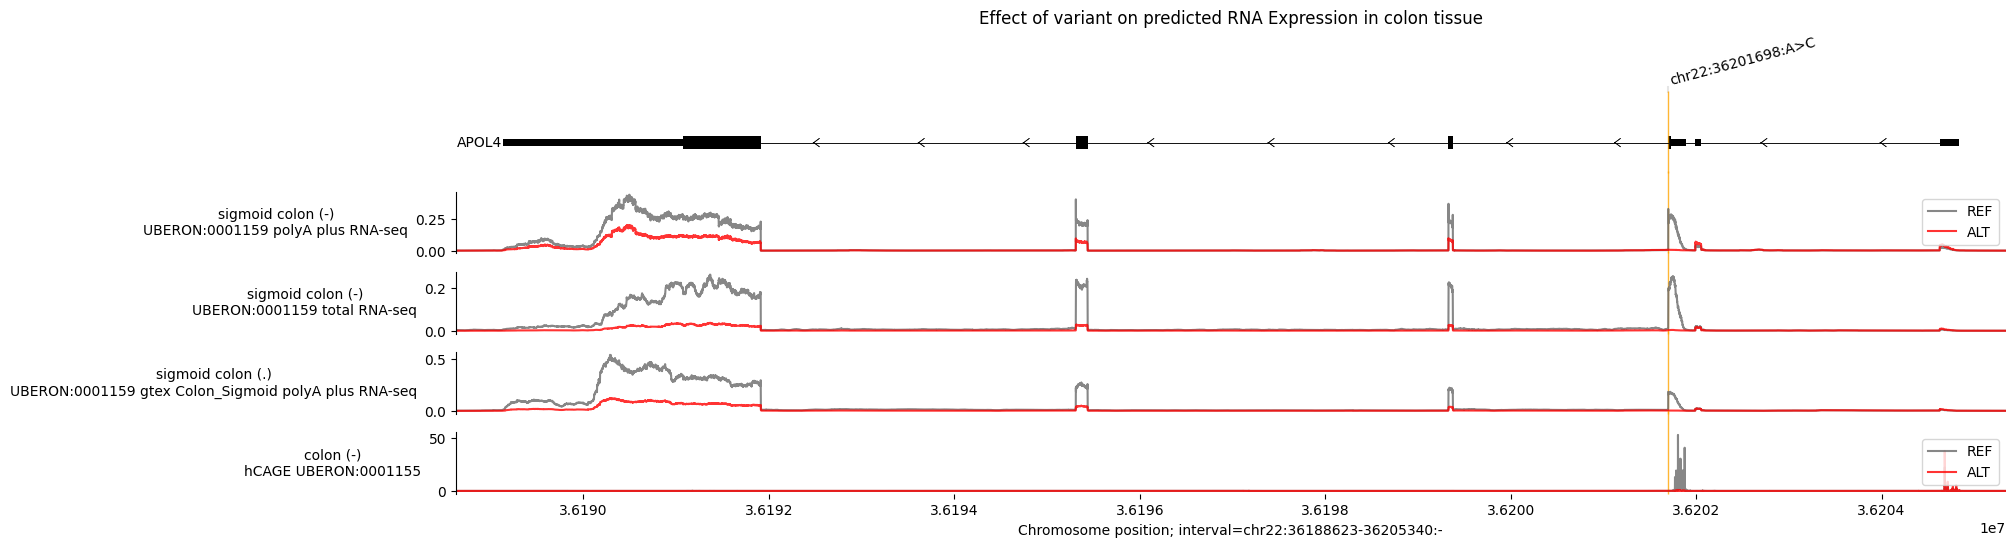

In [14]:
# Define the colors for REF and ALT predictions.
ref_alt_colors = {'REF': 'dimgrey', 'ALT': 'red'}

# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        # RNA-seq tracks.
        plot_components.OverlaidTracks(
            tdata={
                'REF': output.reference.rna_seq.filter_to_nonpositive_strand(),
                'ALT': output.alternate.rna_seq.filter_to_nonpositive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='{biosample_name} ({strand})\n{name}',
        ),
        # CAGE track.
        plot_components.OverlaidTracks(
            tdata={
                'REF': output.reference.cage.filter_to_nonpositive_strand(),
                'ALT': output.alternate.cage.filter_to_nonpositive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='{biosample_name} ({strand})\n{name}',
        ),
    ],
    annotations=[plot_components.VariantAnnotation([variant])],
    interval=apol4_interval,
    title='Effect of variant on predicted RNA Expression in colon tissue',
)

You can see here that the predicted RNA-seq values for the alternative allele
are much lower across the gene (ALT lines are lower than REF lines), which is
also reflected in the bottom CAGE track. Additionally, you can see where the
variant might be inducing an exon skipping event (in the exon where the ALT line
is zero but the REF has a peak).

### Plot custom annotation (e.g., polyadenylation sites)

In [15]:
# Run predictions with an additional ontology to highlight differences across
# tissues.
ontology_terms = [
    'UBERON:0001159',  # Colon - Sigmoid.
    'UBERON:0002048',  # lung.
]

# Make predictions.
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
    },
    ontology_terms=ontology_terms,
)

There are 3 annotated pA sites overlapping APOL4 transcripts, as defined by
[PolyADBv3](https://exon.apps.wistar.org/polya_db/v3/misc/download.php) [(Wang et al. 2018)](https://pubmed.ncbi.nlm.nih.gov/29069441/).
We can define these locations as 1bp intervals in hg38 coordinates.

In [16]:
# Define pA sites in hg38 coordinates.
apol4_pAs = [genome.Interval('chr22', 36_189_128, 36_189_129, '-'),
             genome.Interval('chr22', 36_190_089, 36_190_090, '-'),
             genome.Interval('chr22', 36_190_144, 36_190_145, '-')]

# Define plotting interval as first/last pA plus some offset distance.

offset = 200
pA_interval = genome.Interval('chr22',
                              36_189_128 - offset,
                              36_190_145 + offset,
                              '-')

# Define intervals annotation.
pA_labels = ['pA_3', 'pA_2', 'pA_1']

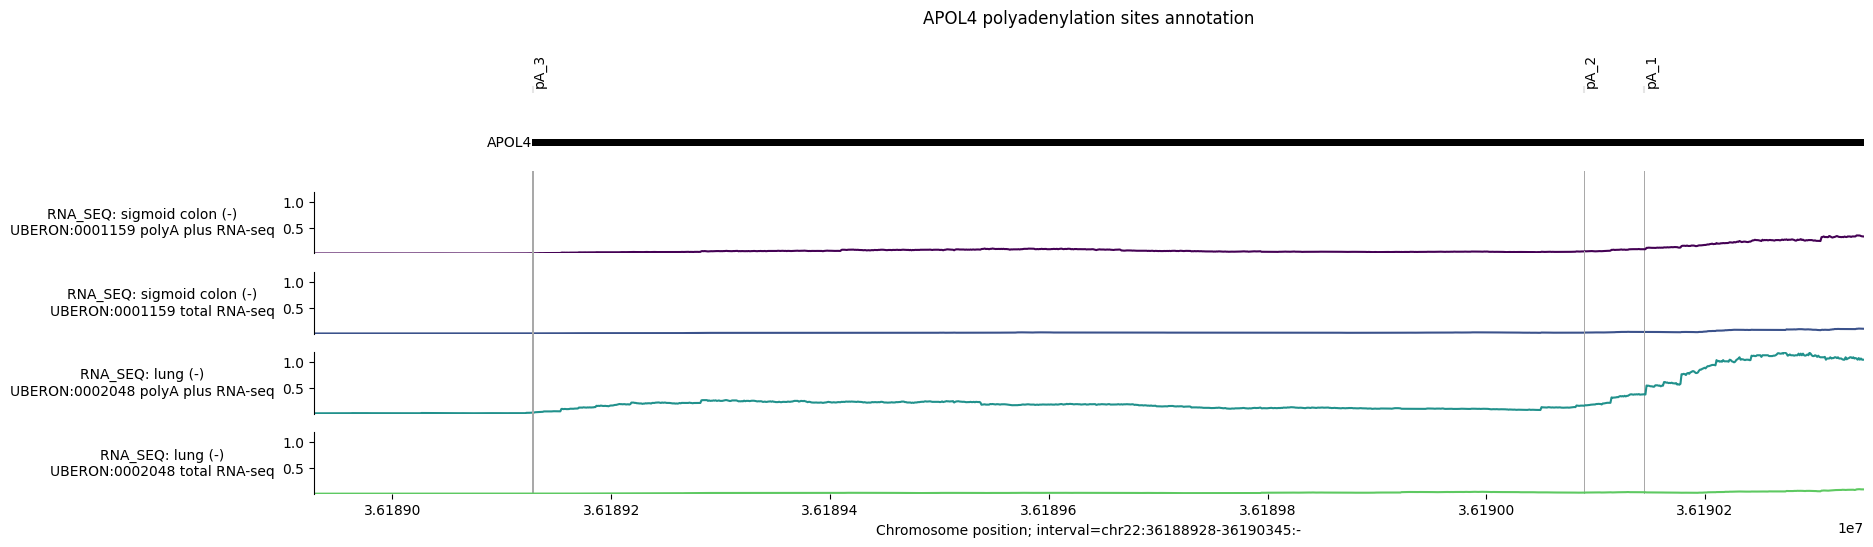

In [17]:
# Build plot.
# NOTE: Depending on annotation distance and interval zoom some annotations may # appear as overlapping.

plot = plot_components.plot(
    [plot_components.TranscriptAnnotation(longest_transcripts),
        # RNA-seq tracks.
        plot_components.Tracks(
            tdata = output.rna_seq.filter_to_negative_strand(),
            ylabel_template = 'RNA_SEQ: {biosample_name} ({strand})\n{name}',
            shared_y_scale = True,
            )
    ],
    annotations=[
        plot_components.IntervalAnnotation(apol4_pAs,
                                           alpha = 1,
                                           labels = pA_labels,
                                           label_angle = 90)],
    interval = pA_interval,
    title='APOL4 polyadenylation sites annotation',

)

## Chromatin accessibility

Chromatin accessibility is primarily captured by the model outputs `DNASE` and
`ATAC`. Here is an example of predictions for the same genomic interval
containing the gene *APOL4*. There are a large variety of tissues and cell-types
available, but let's focus on plotting predictions for intestinal tract tissues:

In [18]:
# List of IDs corresponding to various intestinal tissues.
ontology_terms = [
    'UBERON:0000317',
    'UBERON:0001155',
    'UBERON:0001157',
    'UBERON:0001159',
    'UBERON:0004992',
    'UBERON:0008971',
]

In [19]:
# Make predictions.
output = dna_model.predict_interval(
    interval,
    requested_outputs={
        dna_client.OutputType.DNASE,
        dna_client.OutputType.ATAC,
    },
    ontology_terms=ontology_terms,
)

Chromatin accessibility can indicate regions of regulatory activity. Let's use
`plot_components.IntervalAnnotation()` to plot additional annotation on putative
promoter regions from GENCODE
[human](https://www.gencodegenes.org/human/release_46.html) or [mouse](https://www.gencodegenes.org/mouse/release_M23.html)
to see if they overlap regions predicted to be accessible:

In [20]:
# Two putative promoter intervals from Ensembl.
promoter_intervals = [
    genome.Interval(
        'chr22', 36_201_799, 36_202_681, name='Ensembl_promoter:ENSR00001367790'
    ),
    genome.Interval(
        'chr22', 36_204_705, 36_205_330, name='Ensembl_promoter:ENSR00001367792'
    ),
]

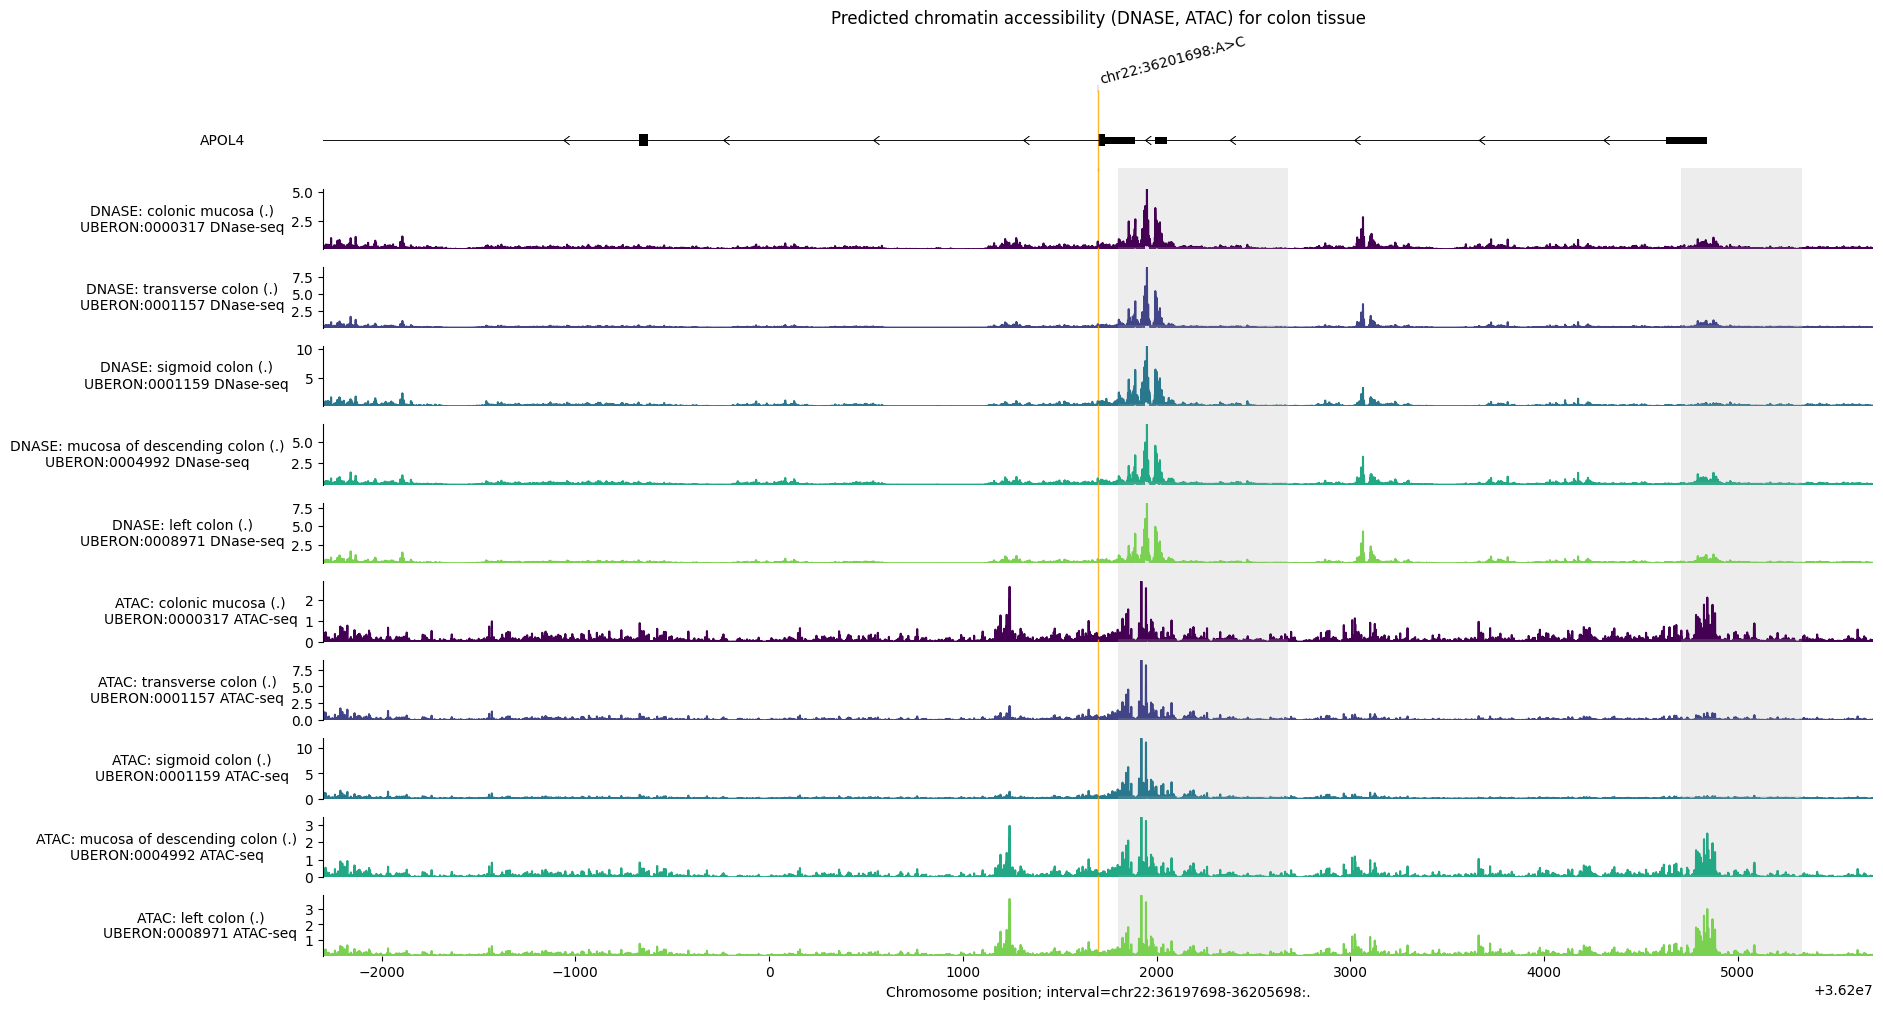

In [21]:
# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=output.dnase,
            ylabel_template='DNASE: {biosample_name} ({strand})\n{name}',
        ),
        plot_components.Tracks(
            tdata=output.atac,
            ylabel_template='ATAC: {biosample_name} ({strand})\n{name}',
        ),
    ],
    # Plot an 8kb window around the variant.
    interval=variant.reference_interval.resize(8000),
    annotations=[
        plot_components.VariantAnnotation([variant]),
        plot_components.IntervalAnnotation(promoter_intervals),
    ],
    title='Predicted chromatin accessibility (DNASE, ATAC) for colon tissue',
)

Some observations from this plot:
*   Elevated `DNASE` and `ATAC` signals overlap
both putative promoter regions highlighted in grey, but additional chromatin
accessibility peaks suggest there may be other regulatory elements in this
region.
*   `DNASE` and `ATAC` signals are similar but not identical, reflecting
differences in assay protocol.
*  Accessibility is not especially high around the variant (orange line).

## Splicing

Splicing effects are primarily captured by the model outputs `SPLICE_SITES`,
`SPLICE_SITE_USAGE`, and `SPLICE_JUNCTIONS`. Here is an example of splicing
predictions in a genomic interval containing the gene *APOL4*.

Since `RNA_SEQ` data also captures splicing patterns, we can plot it together
with the splicing outputs, allowing us to see how predictions from different
modalities are related:

In [22]:
# List of IDs corresponding to various intestinal tissues.
ontology_terms = [
    'UBERON:0001157',
    'UBERON:0001159',
]

In [23]:
# Make predictions for splicing outputs and RNA_SEQ.
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.SPLICE_SITES,
        dna_client.OutputType.SPLICE_SITE_USAGE,
        dna_client.OutputType.SPLICE_JUNCTIONS,
    },
    ontology_terms=ontology_terms,
)

Note that `SPLICE_SITES` are tissue-agnostic predictions, so the
`ontology_terms` filter is not applied to it.

In [24]:
output.splice_sites.metadata

,name,strand
0,donor,+
1,acceptor,+
2,donor,-
3,acceptor,-


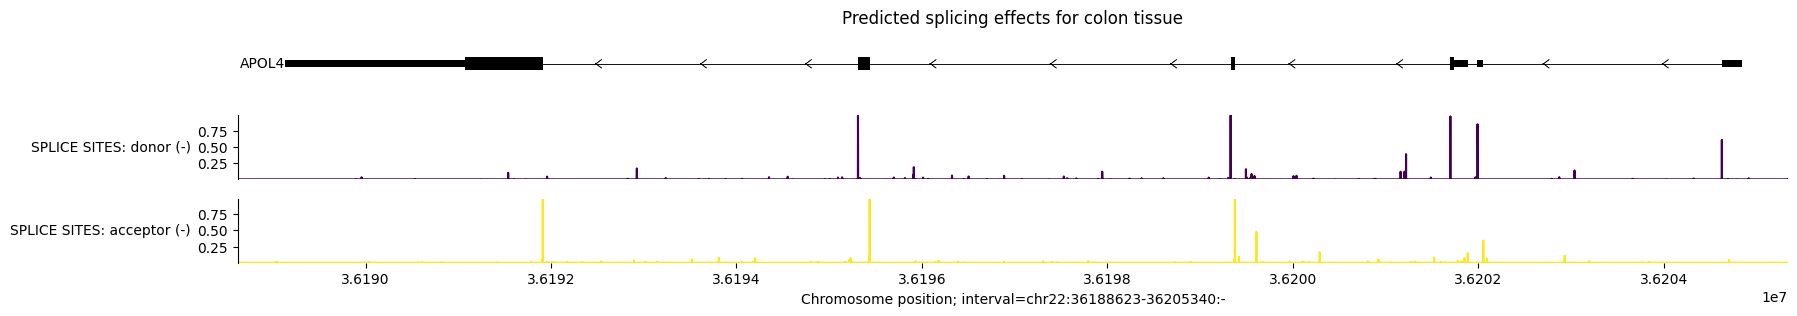

In [25]:
# Build plot.
# Since APOL4 is on the negative DNA strand, we use `filter_negative_strand` to
# consider only negative stranded splice predictions.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=output.splice_sites.filter_to_negative_strand(),
            ylabel_template='SPLICE SITES: {name} ({strand})',
        ),
    ],
    interval=apol4_interval,
    title='Predicted splicing effects for colon tissue',
)

Note how the model predicts acceptor splice sites near the beginnings of exons
and donor splice sites near the ends of exons, whereas splice site usage
predictions have peaks on both sides of exons.

We can visualize the junction split read predictions as arcs using
`plot_components.Sashimi()`. We can also visualize the effect of the variant by
showing both `RNA_SEQ` and splicing predictions on the same plot:

In [26]:
# Make predictions for REF and ALT alleles.
output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs={
        dna_client.OutputType.RNA_SEQ,
        dna_client.OutputType.SPLICE_SITES,
        dna_client.OutputType.SPLICE_SITE_USAGE,
        dna_client.OutputType.SPLICE_JUNCTIONS,
    },
    ontology_terms=ontology_terms,
)

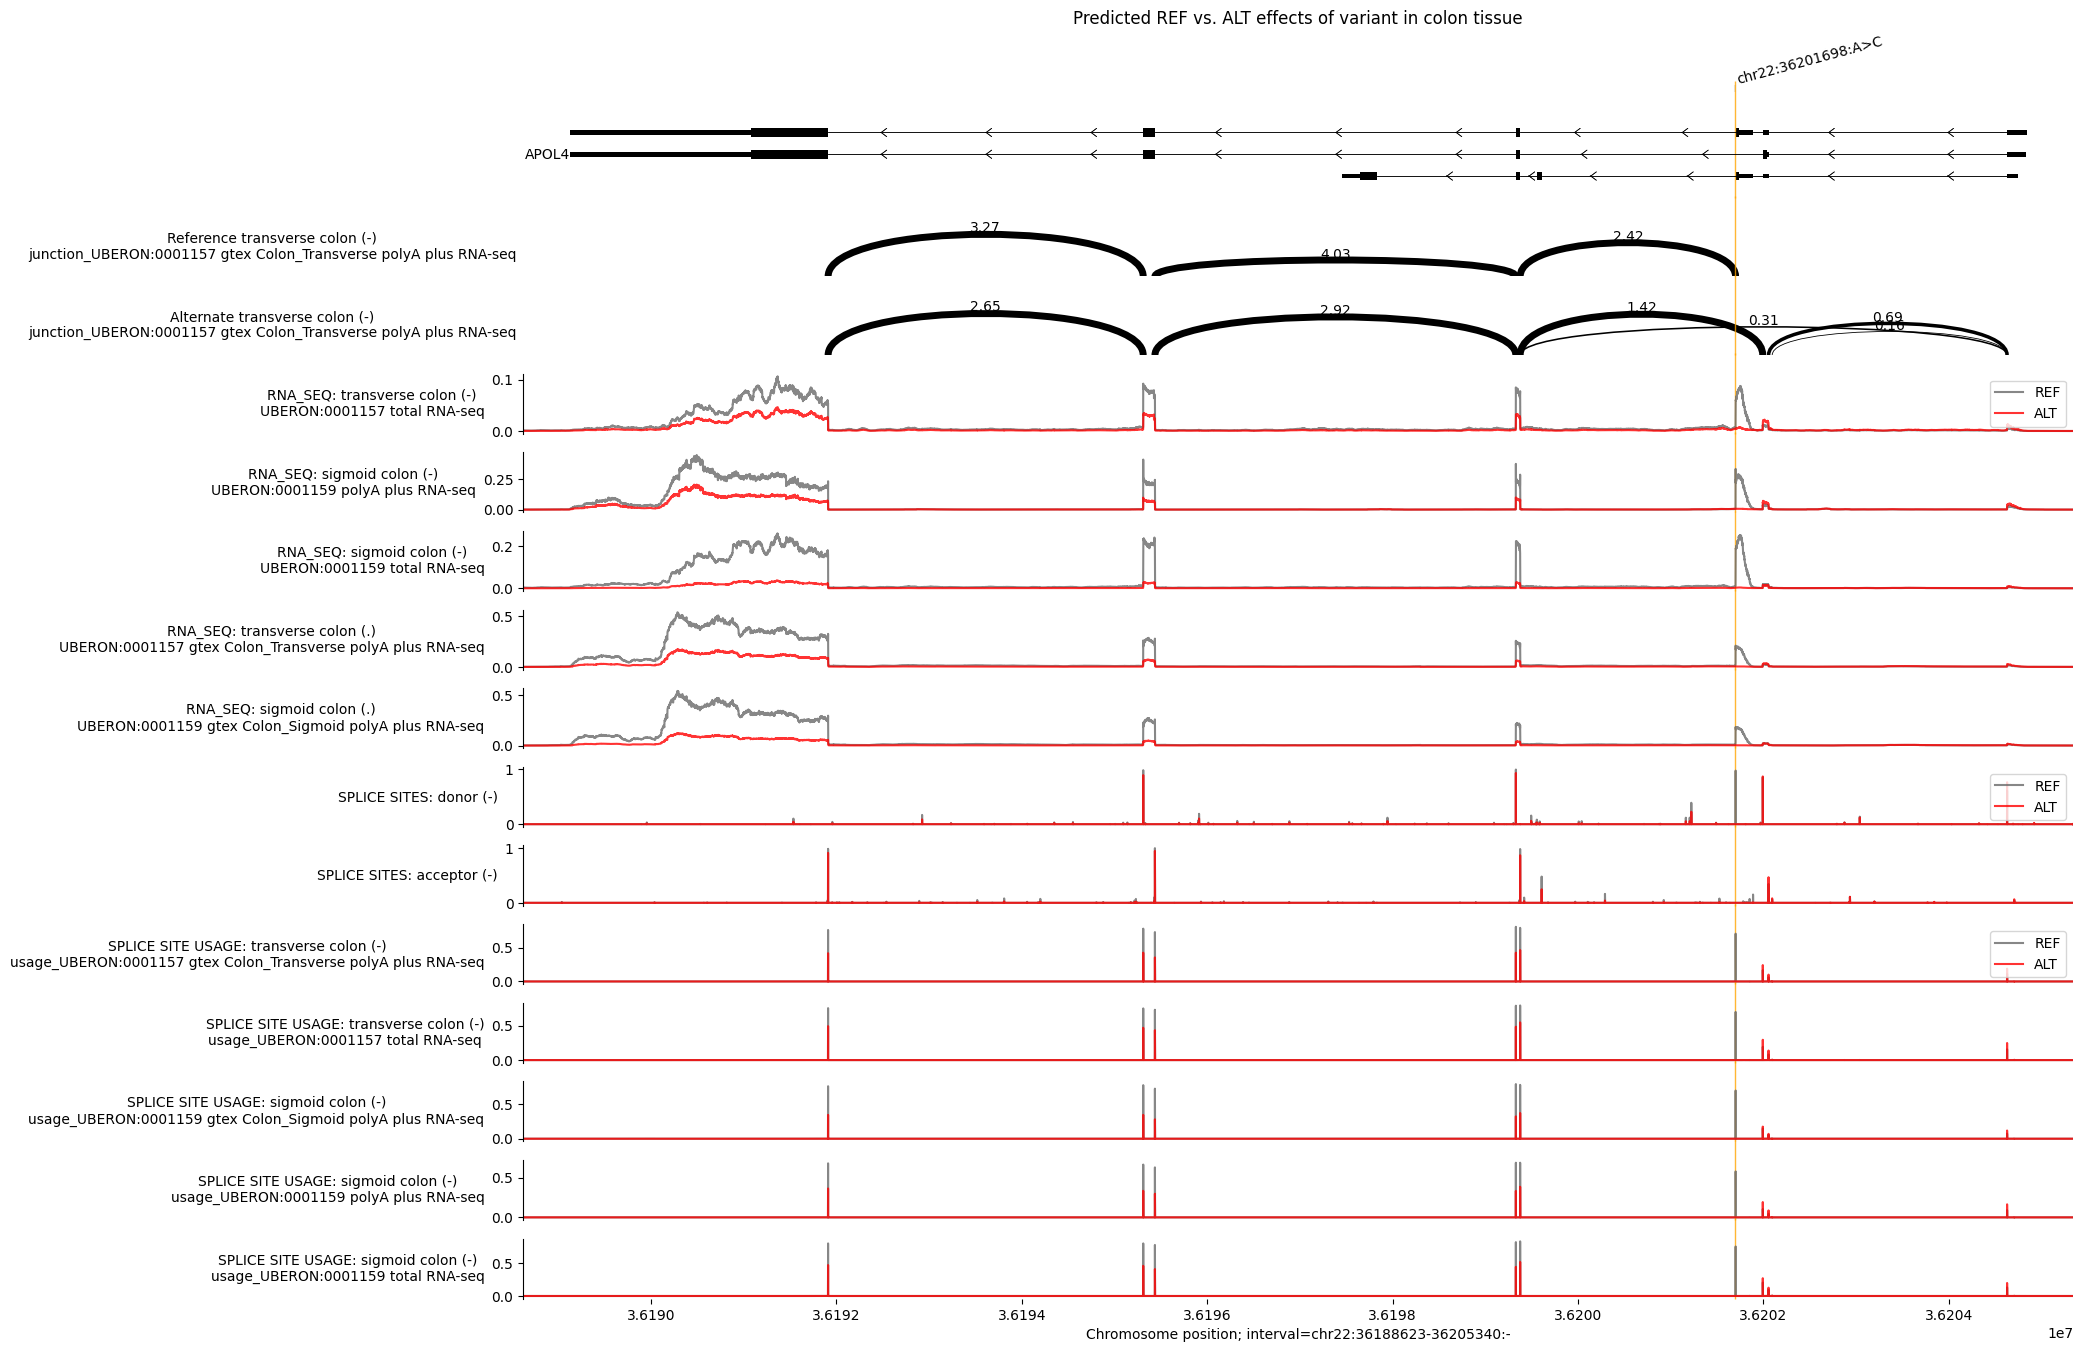

In [27]:
# Get all transcripts, not just the longest one per gene.
transcripts = transcript_extractor.extract(interval)

ref_output = output.reference
alt_output = output.alternate

# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.Sashimi(
            ref_output.splice_junctions
            .filter_to_strand('-')
            .filter_by_tissue('Colon_Transverse'),
            ylabel_template='Reference {biosample_name} ({strand})\n{name}',
        ),
        plot_components.Sashimi(
            alt_output.splice_junctions
            .filter_to_strand('-')
            .filter_by_tissue('Colon_Transverse'),
            ylabel_template='Alternate {biosample_name} ({strand})\n{name}',
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': ref_output.rna_seq.filter_to_nonpositive_strand(),
                'ALT': alt_output.rna_seq.filter_to_nonpositive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='RNA_SEQ: {biosample_name} ({strand})\n{name}',
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': ref_output.splice_sites.filter_to_nonpositive_strand(),
                'ALT': alt_output.splice_sites.filter_to_nonpositive_strand(),
            },
            colors=ref_alt_colors,
            ylabel_template='SPLICE SITES: {name} ({strand})',
        ),
        plot_components.OverlaidTracks(
            tdata={
                'REF': (
                    ref_output.splice_site_usage.filter_to_nonpositive_strand()
                ),
                'ALT': (
                    alt_output.splice_site_usage.filter_to_nonpositive_strand()
                ),
            },
            colors=ref_alt_colors,
            ylabel_template=(
                'SPLICE SITE USAGE: {biosample_name} ({strand})\n{name}'
            ),
        ),
    ],
    interval=apol4_interval,
    annotations=[plot_components.VariantAnnotation([variant])],
    title='Predicted REF vs. ALT effects of variant in colon tissue',
)

## ChIP-Histone

Histone modification marks are captured by the `CHIP_HISTONE` output. Here is an
example of predictions in the same interval and tissues for histone marks
thought to indicate key regulatory effects (e.g., H3K4me3).

Some additional considerations for visualizing `CHIP_HISTONE` predictions:

*   ChIP-Histone (and ChIP-TF) predictions are returned at a coarser resolution
    (128bp), so we need to adjust the interval size plotted to be compatible
    (i.e., its width must be a multiple of 128). This is done automatically by
    the plotting library.
*   Not all biosamples have predictions for all histone marks, but four of the
    major ones (H3K4me3, H3K4me1, H3K27ac, H3K27me3 and H3K36me3) are available
    for 40% of biosamples. Let's see which histone marks are covered by
    biosamples corresponding to colon tissue:

In [28]:
output_metadata.chip_histone[
    output_metadata.chip_histone['biosample_name'].str.contains('colon')
]

,name,strand,Assay title,ontology_curie,biosample_name,biosample_type,biosample_life_stage,histone_mark,data_source,endedness,genetically_modified,nonzero_mean
769,UBERON:0000317 Histone ChIP-seq H3K27ac,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K27ac,encode,single,False,0.749292
770,UBERON:0000317 Histone ChIP-seq H3K27me3,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K27me3,encode,single,False,1.773918
771,UBERON:0000317 Histone ChIP-seq H3K36me3,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K36me3,encode,single,False,1.865919
772,UBERON:0000317 Histone ChIP-seq H3K4me1,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K4me1,encode,single,False,0.941760
773,UBERON:0000317 Histone ChIP-seq H3K4me3,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K4me3,encode,single,False,0.739352
774,UBERON:0000317 Histone ChIP-seq H3K9ac,.,Histone ChIP-seq,UBERON:0000317,colonic mucosa,tissue,adult,H3K9ac,encode,single,False,0.950228
835,UBERON:0001157 Histone ChIP-seq H3K27ac,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K27ac,encode,single,False,0.785410
836,UBERON:0001157 Histone ChIP-seq H3K27me3,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K27me3,encode,single,False,0.825184
837,UBERON:0001157 Histone ChIP-seq H3K36me3,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K36me3,encode,single,False,0.823532
838,UBERON:0001157 Histone ChIP-seq H3K4me1,.,Histone ChIP-seq,UBERON:0001157,transverse colon,tissue,adult,H3K4me1,encode,single,False,0.812938


In [29]:
# List of IDs corresponding to various colon tissues in `CHIP_HISTONE` output.
ontology_terms = [
    'UBERON:0000317',
    'UBERON:0001155',
    'UBERON:0001157',
    'UBERON:0001159',
]

# Make predictions.
output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CHIP_HISTONE},
    ontology_terms=ontology_terms,
)

We can extract the locations of transcription start sites as annotated by
GENCODE using `gene_annotation.extract_tss()`, and plot these using
`plot_components.IntervalAnnotation()`:

In [30]:
gtf_tss = gene_annotation.extract_tss(gtf_longest_transcript)

tss_as_intervals = [
    genome.Interval(
        chromosome=row.Chromosome,
        start=row.Start,
        end=row.End + 1000,  # Add extra 1Kb so the TSSs are visible.
        name=row.gene_name,
    )
    for _, row in gtf_tss.iterrows()
]

We can also reorder tracks so they are grouped by histone mark, and also specify
colors based on their histone mark.

In [32]:
reordered_chip_histone = output.chip_histone.select_tracks_by_index(
    output.chip_histone.metadata.sort_values('histone_mark').index
)

histone_to_color = {
    'H3K27AC': '#e41a1c',
    'H3K36ME3': '#ff7f00',
    'H3K4ME1': '#377eb8',
    'H3K4ME3': '#984ea3',
    'H3K9AC': '#4daf4a',
    'H3K27ME3': '#ffc0cb',
}

track_colors = (
    reordered_chip_histone.metadata['histone_mark']
    .map(lambda x: histone_to_color.get(x.upper(), '#000000'))
    .values
)

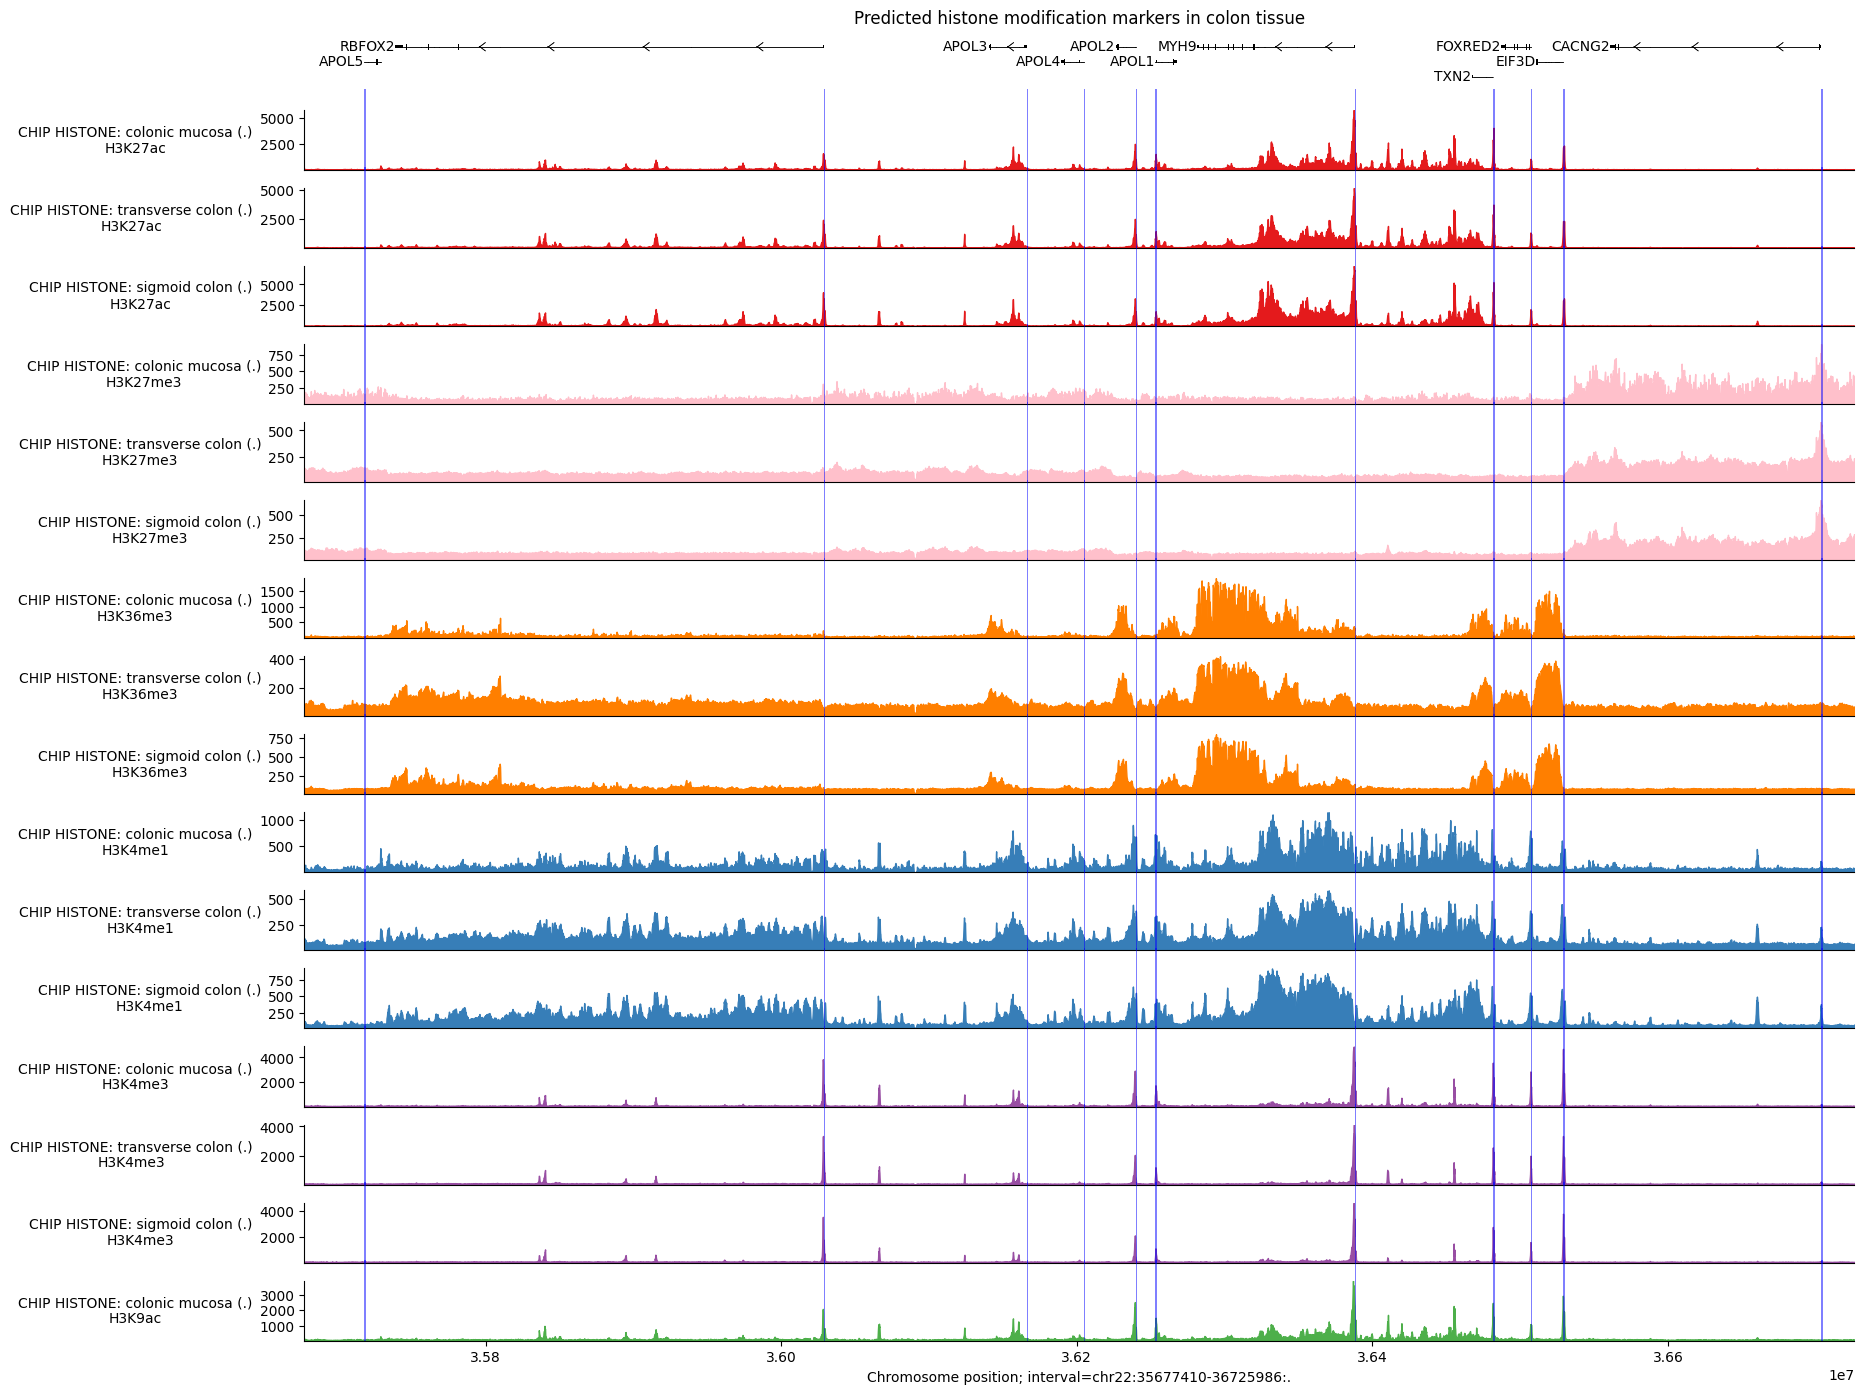

In [33]:
# Build plot.
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=reordered_chip_histone,
            ylabel_template=(
                'CHIP HISTONE: {biosample_name} ({strand})\n{histone_mark}'
            ),
            filled=True,
            track_colors=track_colors,
        ),
    ],
    interval=interval,
    annotations=[
        plot_components.IntervalAnnotation(
            tss_as_intervals, alpha=0.5, colors='blue'
        )
    ],
    despine_keep_bottom=True,
    title='Predicted histone modification markers in colon tissue',
)

We can see that many of the predicted histone modification peaks overlap with
transcription start sites, especially markers associated with promoters
(H3K4me3, H3K27ac, and H3K9ac). Other markers such as H3K36me3 and H3K4me1 are
more associated with gene bodies and enhancers, so these signals are less
pronounced around the TSSs.

## ChIP-TF

Transcription factor (TF) binding patterns are captured by the model's `CHIP_TF`
output. We will visualize these in a similar way to `CHIP_HISTONE` predictions,
with one difference: we need to modify the ontology terms we request in order to
get good coverage of both biosamples of interest and multiple TFs. Many
biosamples have predictions for two major TFs, namely CTCF and POLR2A, but some
cell-lines (HepG2 and K562) have coverage over many more TFs (501 and 269
respectively).

Here, we will also demonstrate two helpful utilities: selecting specific tracks
from a `TrackData` object and aggregating predictions across tracks in a
`TrackData` object.

In [34]:
ontology_terms = [
    'UBERON:0001159',  # Sigmoid colon.
    'UBERON:0001157',  # Transverse colon.
    'EFO:0002067',  # K562.
    'EFO:0001187',  # HepG2.
]

output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CHIP_TF},
    ontology_terms=ontology_terms,
)

Say we then only want to work with the K562 and HepG2 part of the output. We can
accomplish this by calling `filter_tracks`:

In [35]:
ontology_terms = [
    'EFO:0002067',  # K562.
    'EFO:0001187',  # HepG2.
]

output_chip_tf = output.chip_tf.filter_tracks(
    (output.chip_tf.metadata['ontology_curie'].isin(ontology_terms)).values
)
len(output_chip_tf.metadata)

845

In these 845 tracks across the 2 cell types, the maximum predicted values vary
considerably:

In [36]:
max_predictions = output_chip_tf.metadata[
    ['ontology_curie', 'biosample_name', 'transcription_factor']
].copy()

max_predictions.loc[:, 'max_prediction'] = output_chip_tf.values.max(axis=0)
max_predictions.sort_values('max_prediction', ascending=False).reset_index(
    drop=True
)

,ontology_curie,biosample_name,transcription_factor,max_prediction
0,EFO:0002067,K562,PKNOX1,20608.0
1,EFO:0002067,K562,POLR2G,20608.0
2,EFO:0001187,HepG2,RBFOX2,19328.0
3,EFO:0002067,K562,GABPB1,18304.0
4,EFO:0001187,HepG2,REST,15488.0
...,...,...,...,...
840,EFO:0001187,HepG2,TCF12,183.0
841,EFO:0001187,HepG2,GPBP1L1,173.0
842,EFO:0002067,K562,ZNF778,159.0
843,EFO:0002067,K562,XRCC4,149.0


We can filter the tracks down to only those with a maximum value of at least
10000:

In [37]:
print(f'Number of tracks before filtering: {len(output_chip_tf.metadata)}')

output_filtered = output_chip_tf.filter_tracks(
    output_chip_tf.values.max(axis=0) > 8000
)
print(f'Number of tracks after filtering: {len(output_filtered.metadata)}')

Number of tracks before filtering: 845
Number of tracks after filtering: 14


This is a more manageable number of tracks to visualize. Let's build up the plot
as before:

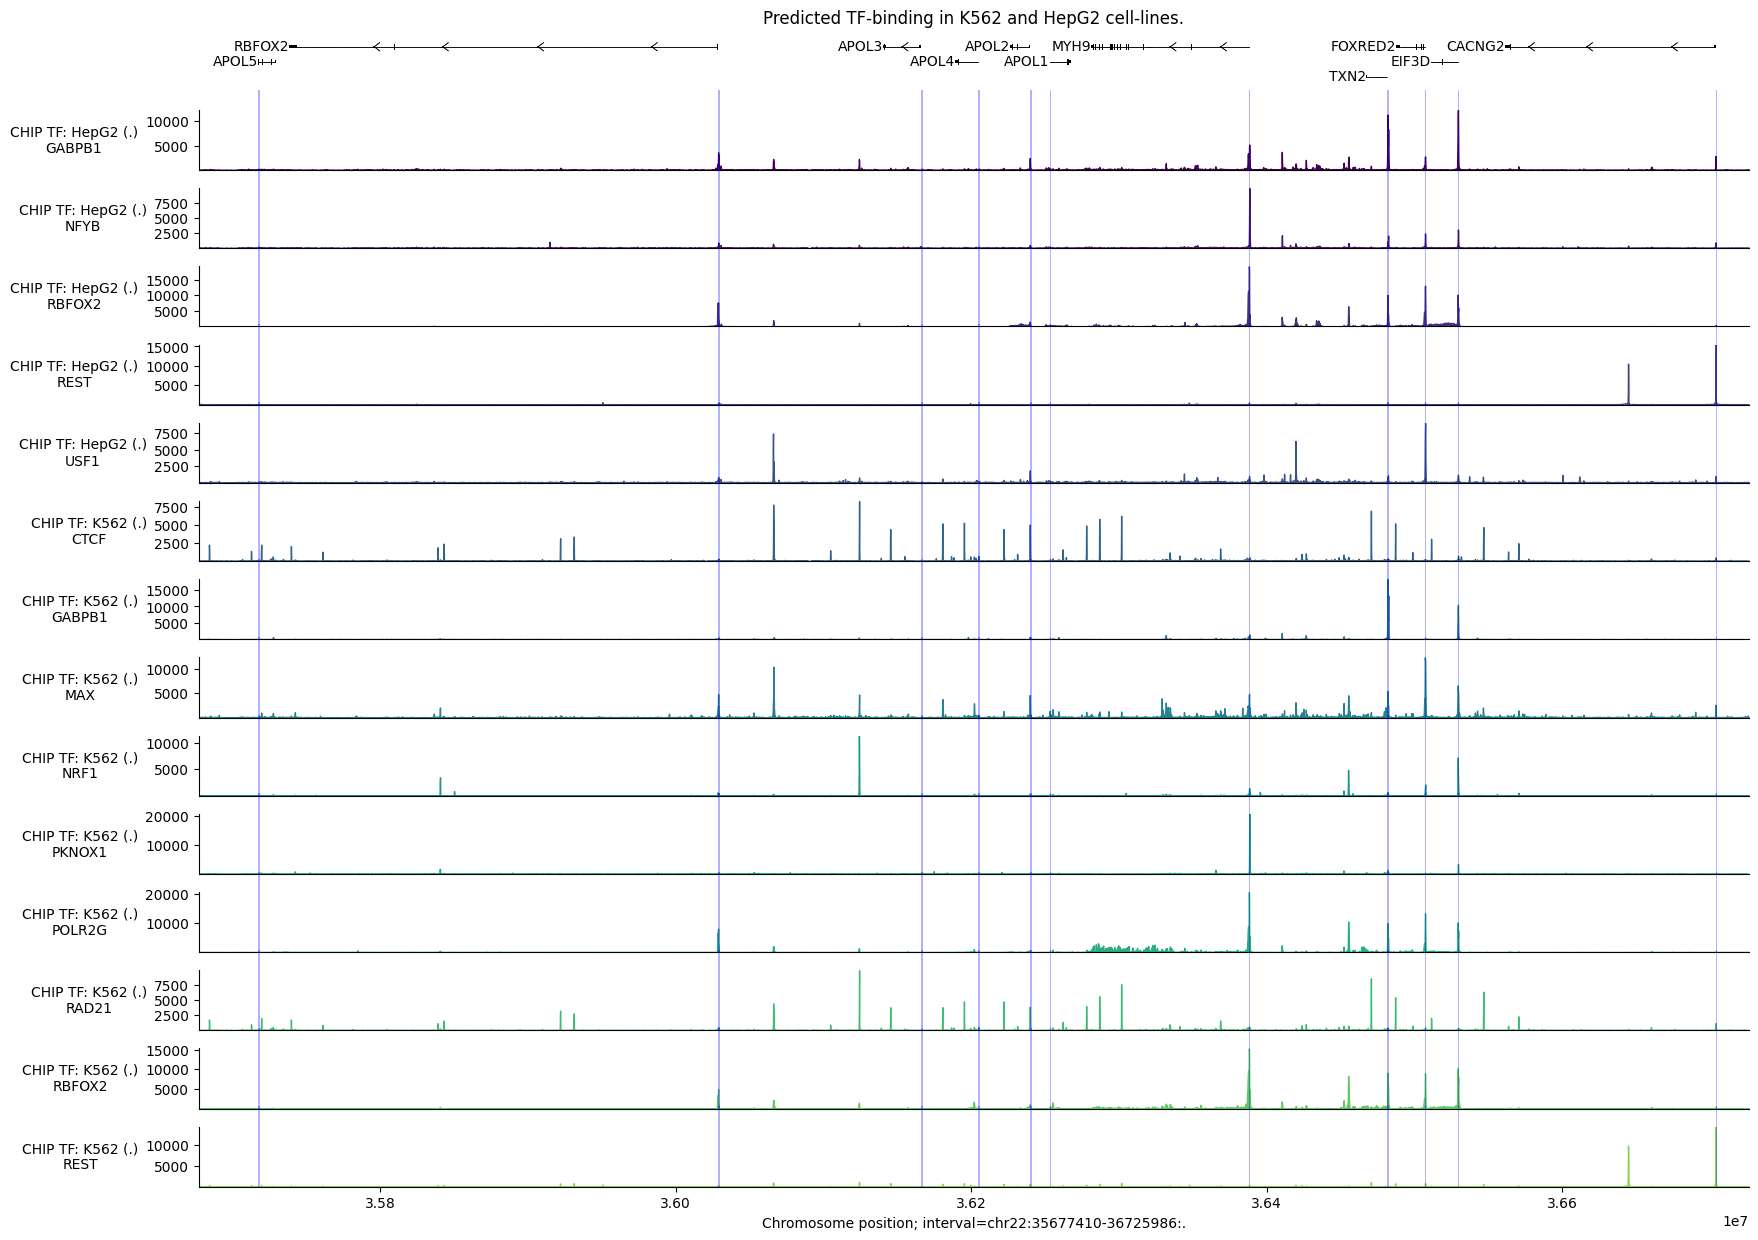

In [38]:
# Build plot.
plot_components.plot(
    components=[
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.Tracks(
            tdata=output_filtered,
            ylabel_template=(
                'CHIP TF: {biosample_name} ({strand})\n{transcription_factor}'
            ),
            filled=True,
        ),
    ],
    interval=interval,
    title='Predicted TF-binding in K562 and HepG2 cell-lines.',
    despine_keep_bottom=True,
    annotations=[
        plot_components.IntervalAnnotation(
            tss_as_intervals, alpha=0.3, colors='blue'
        )
    ],
)
plt.show()

In this figure, we see that CTCF binding sites strongly coincide with those of
the cohesin complex protein RAD21. Binding locations for the same protein (e.g.,
RBFOX2, REST) appear largely the same across these two cell types, with some
change in magnitude. Peaks in predicted POLR2G binding, a component of RNA
Polymerase II, typically occur near TSS sites.

We can use the same process to select tracks with high peaks anywhere within the
*APOL4* gene interval:

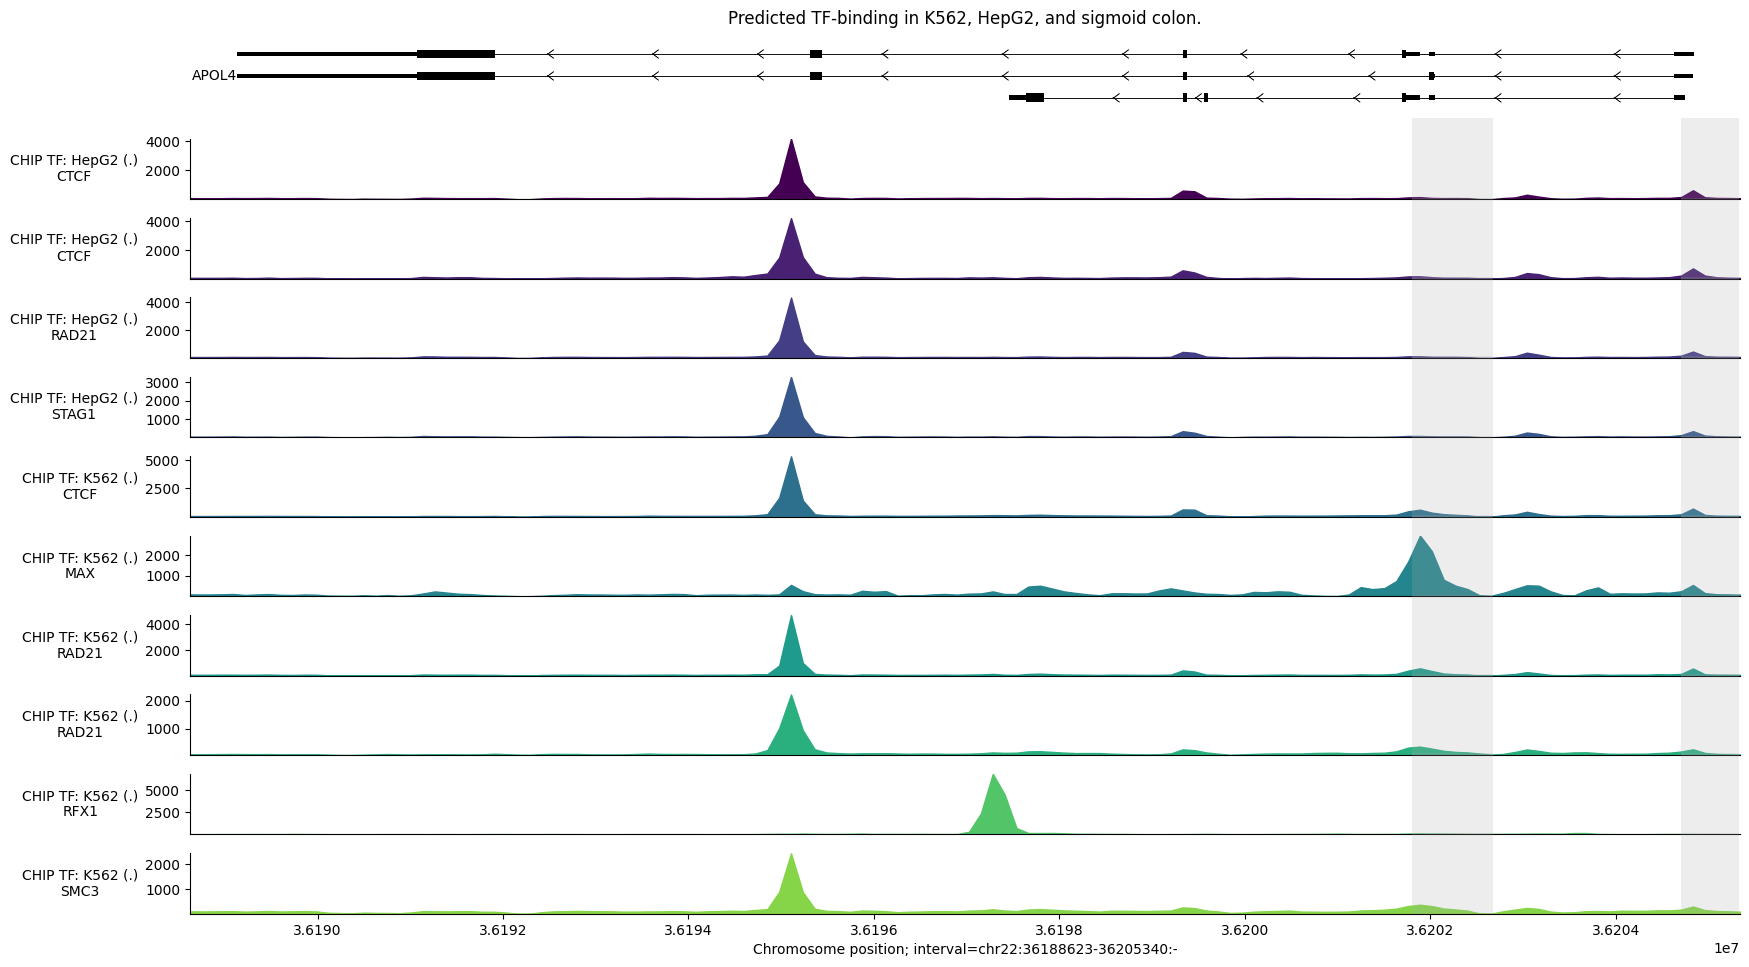

In [39]:
# Compute max predicted values per track in the APOL4 gene interval.
max_predictions = output.chip_tf.slice_by_interval(
    apol4_interval, match_resolution=True
).values.max(axis=0)

# Filter to the 10 tracks with the highest predictions.
output_filtered = output.chip_tf.filter_tracks(
    (max_predictions >= np.sort(max_predictions)[-10])
)

# Build plot.
plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.Tracks(
            tdata=output_filtered,
            ylabel_template=(
                'CHIP TF: {biosample_name} ({strand})\n{transcription_factor}'
            ),
            filled=True,
        ),
    ],
    interval=apol4_interval,
    annotations=[plot_components.IntervalAnnotation(promoter_intervals)],
    despine_keep_bottom=True,
    title='Predicted TF-binding in K562, HepG2, and sigmoid colon.',
)
plt.show()

We observe a strong predicted CTCF peak near the second-to-last exon (counting
from the right), which is predicted across different tissues. We also see peaks
for (phosphorylated) POL2 binding around one of the putative promoters.

We can average the signal for a transcription factor across tissues to simplify
the plot. For example, to plot the mean CTCF signal across tissues, we first
need to construct a new `TrackData` object:

In [40]:
mean_ctcf = output_filtered.values[
    :, output_filtered.metadata['transcription_factor'] == 'CTCF'
].mean(axis=1)

# Construct a new TrackData object from the mean values.
tdata_mean_ctcf = track_data.TrackData(
    values=mean_ctcf[:, None],
    metadata=pd.DataFrame(
        {'transcription_factor': ['CTCF'], 'name': ['mean'], 'strand': ['.']}
    ),
    interval=output_filtered.interval,
    resolution=output_filtered.resolution,
)

And then plot as usual:

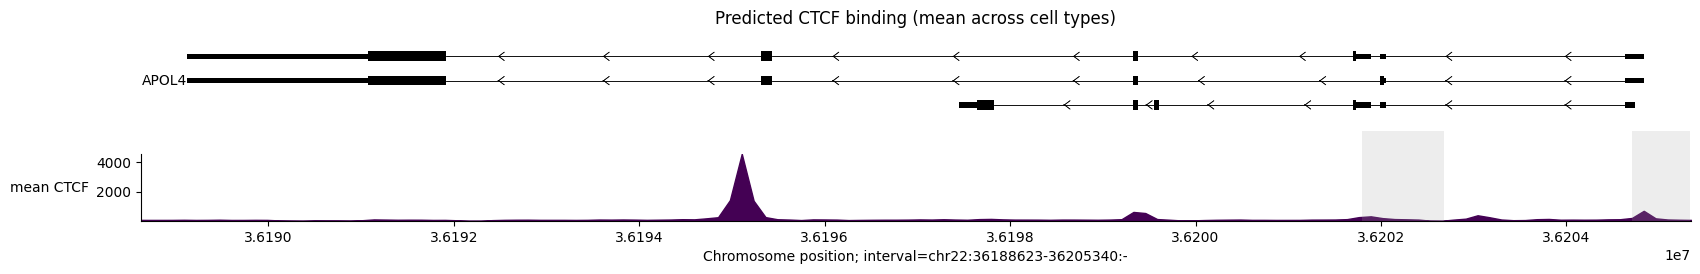

In [41]:
plot_components.plot(
    [
        plot_components.TranscriptAnnotation(transcripts),
        plot_components.Tracks(
            tdata=tdata_mean_ctcf,
            ylabel_template='{name} {transcription_factor}',
            filled=True,
        ),
    ],
    interval=apol4_interval,
    annotations=[plot_components.IntervalAnnotation(promoter_intervals)],
    despine_keep_bottom=True,
    title='Predicted CTCF binding (mean across cell types)',
)
plt.show()

## Contact maps

Relative frequency of physical contacts between pairwise genetic positions are
captured by the model's `CONTACT_MAPS` output. This output type is provided at
even coarser resolution (2048bp), so we can only consider intervals that span
distances larger than this.

Let's make the contact map predictions for a colon cell line:

In [ ]:
# EFO:0001196 IMR90

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

colors = [
 (1.0, 1.0, 1.0),
 (1.0, 0.92, 0.92),
 (1.0, 0.8, 0.8),
 (1.0, 0.6, 0.6),
 (1.0, 0.4, 0.4),
 (1.0, 0.294, 0.294)
]

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_red",
    colors
)
import matplotlib as mpl

mpl.colormaps.register(custom_cmap)

In [117]:
# Define interval to make predictions for (used throughout this tutorial).
# Note that the interval width must be one of the supported sequence lengths.
# chr15:60,400,949-61,300,000
# chr15:59,500,000-60,600,000 > 1Mb
# chr10:84,065,000-84,700,000
# chr11:13685587-14315305
# chr3:181558758-182402768
# chr2:30623986-31396748
# ('chr8', 125_187_758, 125_487_758)
interval = genome.Interval('chr8', 125_187_758, 125_487_758).resize(
    dna_client.SEQUENCE_LENGTH_1MB
)
plot_interval = genome.Interval('chr8', 125_187_758, 125_487_758)

In [118]:
ontology_terms = [
    'EFO:0003042',  # EFO:0001196 IMR90.  EFO:0003042 6 H1-hESCs data
]

output = dna_model.predict_interval(
    interval=interval,
    requested_outputs={dna_client.OutputType.CONTACT_MAPS},
    ontology_terms=ontology_terms,
)

And plot the predicted DNA-DNA contacts:

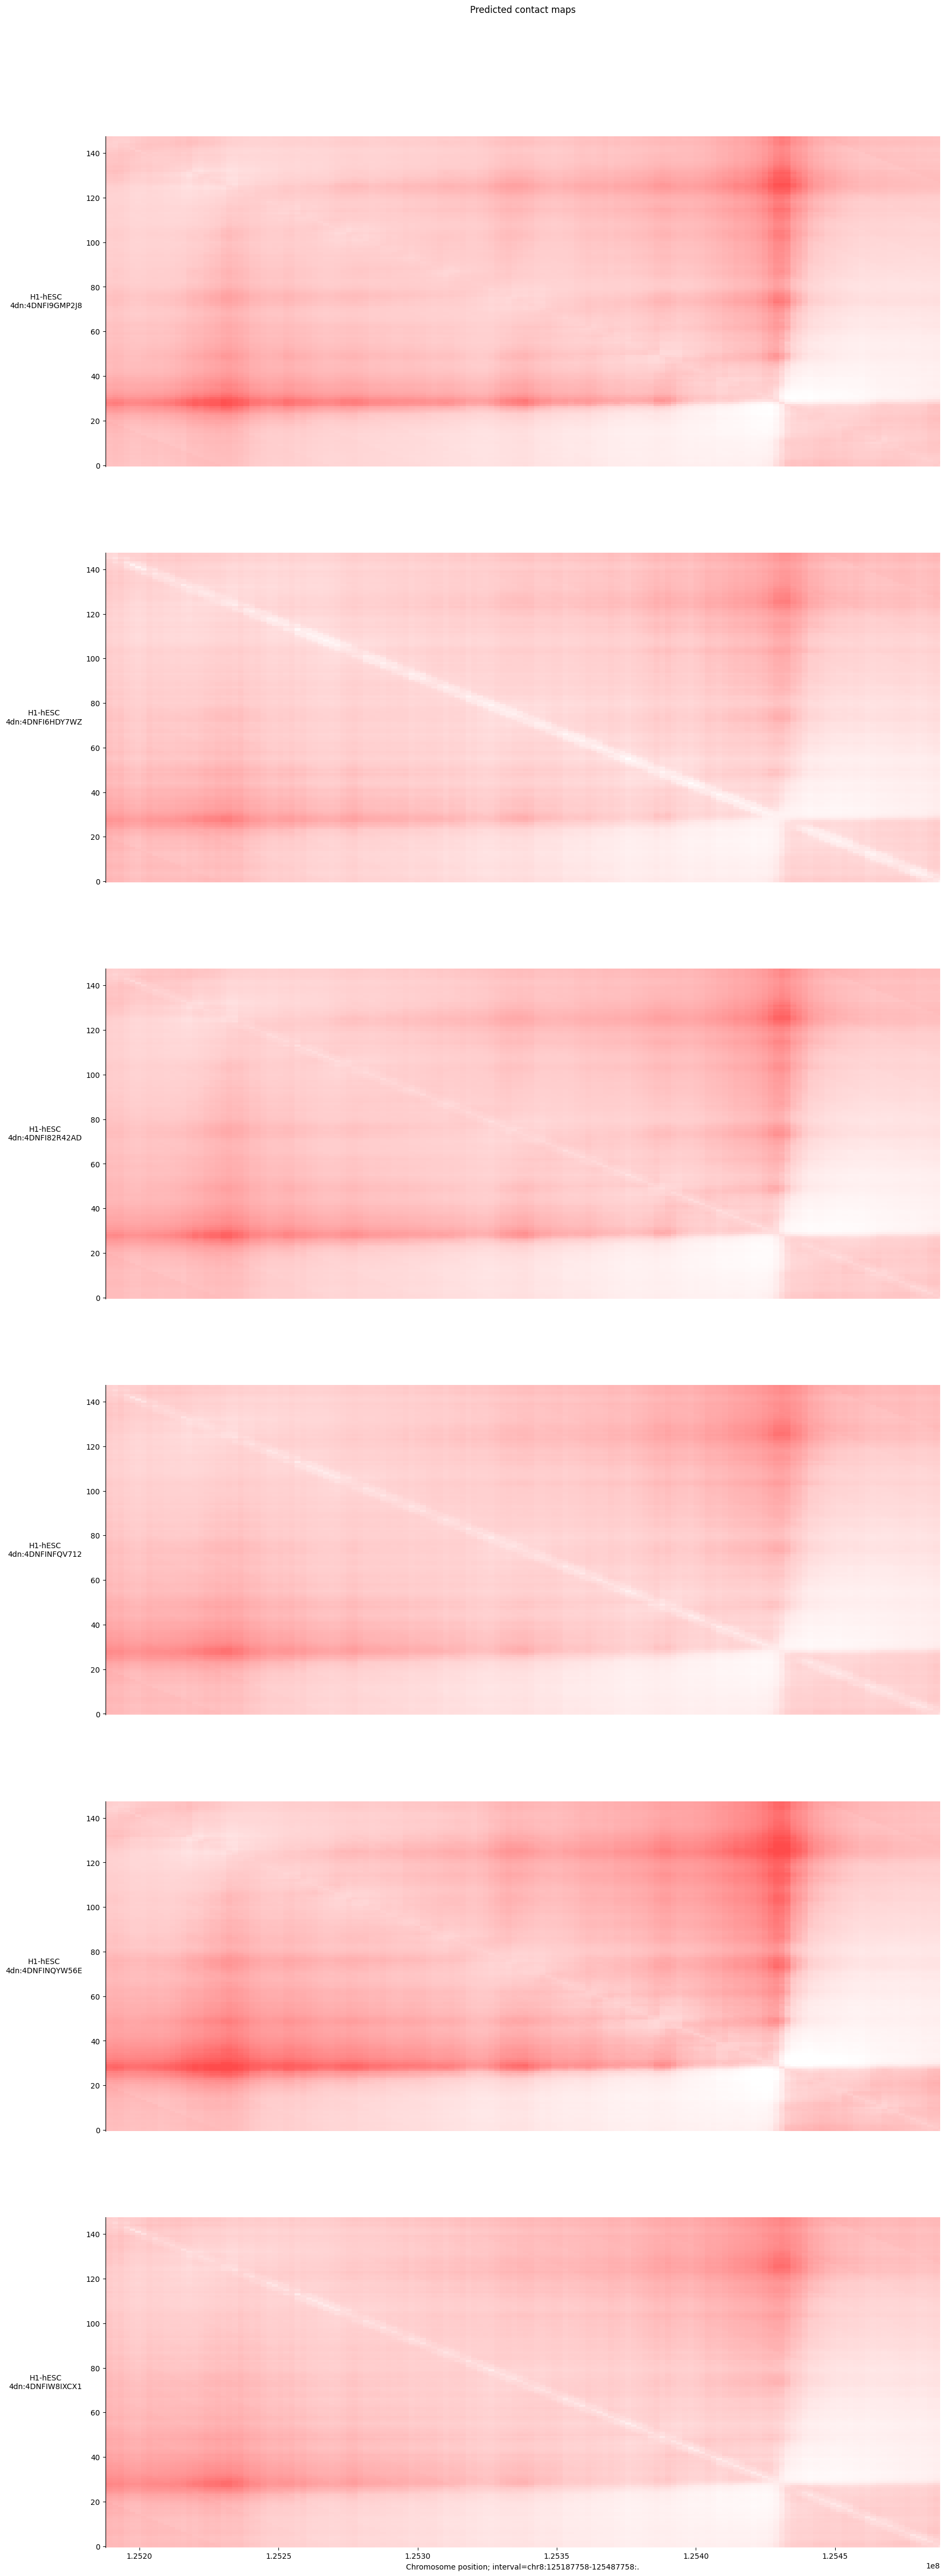

In [119]:
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.ContactMaps(
            tdata=output.contact_maps,
            ylabel_template='{biosample_name}\n{name}',
            cmap='custom_red',
            vmax=1.5,
            vmin=0.0
        ),
    ],
    interval=plot_interval,
    title='Predicted contact maps',
)
plot.savefig("contact_map.png", dpi=300, bbox_inches="tight")
plt.show()

Three prominent interacting regions, potentially representing
topologically-associated domains (TADs), are visible as blocks. This interaction
signal appears to be stronger in the first plot.

## Ref-ALT Contact Maps

A previously identified variant in this region (`chr22_36201698_A_C`) affects
both the expression and splicing of the *APOL4* gene. Specifically, the
alternative allele (C) is linked to reduced *APOL4* expression.

To visualize what AlphaGenome predicts for this variant, we can:

*   Compute predictions for the REF and ALT sequences using
    `dna_model.predict_variant`.
*   Remove positive-stranded tracks (as *APOL4* is transcribed from the negative
    DNA strand).
*   Zoom in to the region around the gene *APOL4*.
*   Highlight the location of the variant using
    `plot_components.VariantAnnotation`.
*   Increase the relative height of the transcripts section to better view the
    gene structure as annotated by GENCODE.

In [120]:
# Define the variant of interest.
# rs16900452 - chr8:125230758-125230958 hg38
variant_string = 'chr8:125230758:G>A'
variant = genome.Variant.from_str(variant_string)
variant

Variant(chromosome='chr8', position=125230758, reference_bases='G', alternate_bases='A', name='')

In [121]:
# chr8:125187758-125487758 hg38
interval = genome.Interval('chr8', 125_187_758, 125_487_758).resize(
    dna_client.SEQUENCE_LENGTH_1MB
)
plot_interval = genome.Interval('chr8', 125_187_758, 125_487_758)

In [122]:
# Make predictions for sequences containing the REF and ALT alleles.
ontology_terms = [
    'EFO:0003042',  # EFO:0003042 including 6 H1-hESCs data
]
output = dna_model.predict_variant(
    interval=interval,
    variant=variant,
    requested_outputs={
        dna_client.OutputType.CONTACT_MAPS
    },
    ontology_terms=ontology_terms,
)

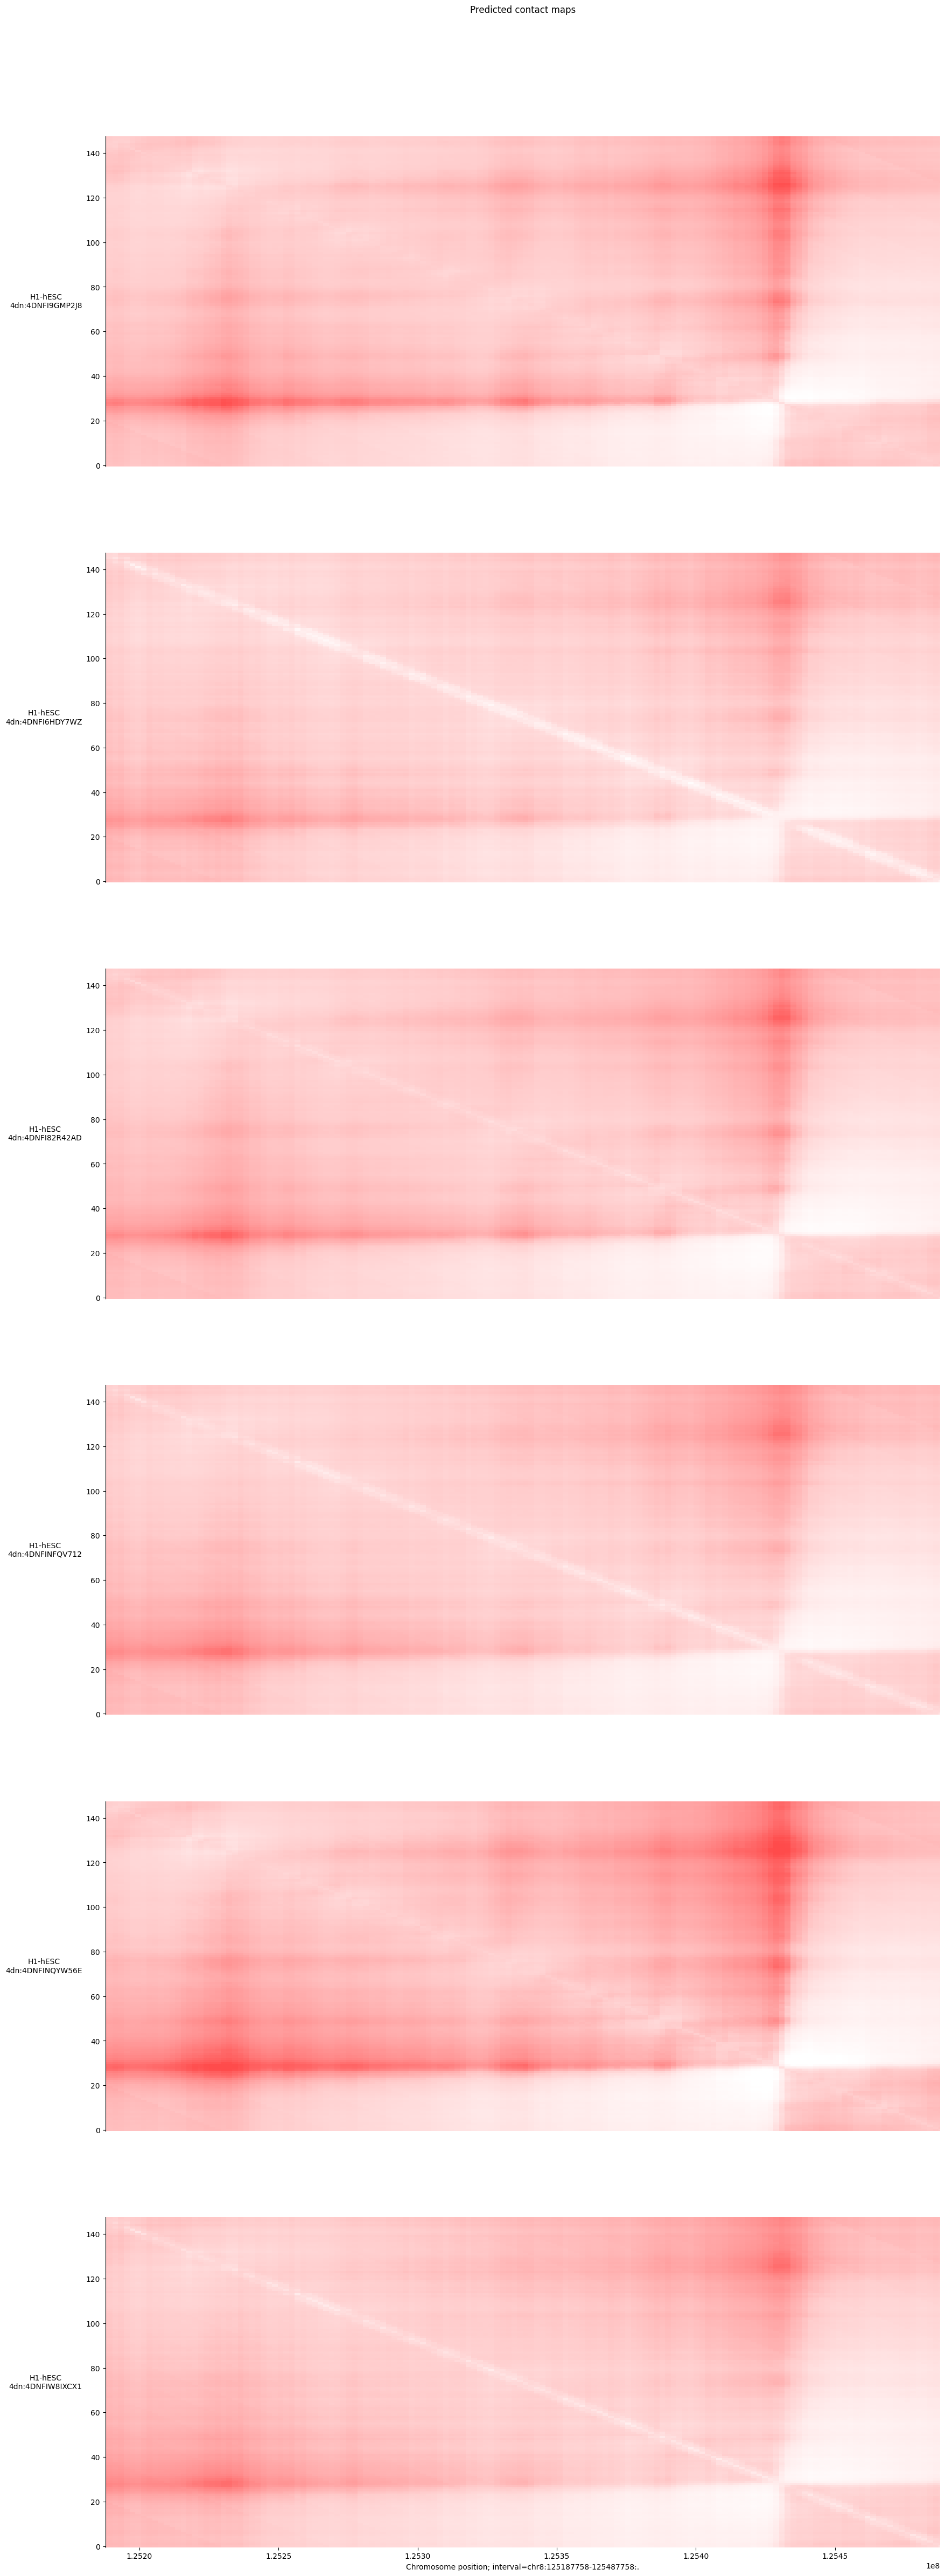

In [123]:
plot = plot_components.plot(
    [
        plot_components.TranscriptAnnotation(longest_transcripts),
        plot_components.ContactMaps(
            tdata=output.reference.contact_maps,
            ylabel_template='{biosample_name}\n{name}',
            cmap='custom_red',
            vmax=1.5,
            vmin=0.0
        ),
    ],
    interval=plot_interval,
    title='Predicted contact maps',
)
plot.savefig("contact_map.png", dpi=300, bbox_inches="tight")
plt.show()

## Conclusion

Congratulations! You have now completed the tour of the visualization library
and learned how to visualize the core modalities predicted by AlphaGenome.